# GIS analysis with geopandas - CO weed sales

Let's take a look at one year of [county-level cannabis sales data in Colorado](https://www.colorado.gov/pacific/revenue/colorado-marijuana-sales-reports).

**Our goal**: To map per-capita weed sales by county in 2017.

**Our data**: A CSV lives here: `../../data/colo-county-cannabis-sales-2017.csv`.

A few things to note about this data:
- Every row in our data is the sum of one month of sales for one category ("retail" or "medical") for one county
- Not every county in Colorado has retail pot shops
- To maintain taxpayer privacy, the state releases aggregate sales data _only_ for counties with at least three dispensaries, and then only if none represent more than 80 percent of total sales, according to the Colorado Department of Revenue. Totals for counties that don't meet these criteria are represented in the data as 'NR'

Other data we will use as we explore this topic:
- `../../data/colo-county-pop.csv`: A CSV with Colorado county [FIPS](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standards) codes, county names and 2016 population estimates.
- `../../data/co-counties.shp`: A Census Bureau [shapefile](https://en.wikipedia.org/wiki/Shapefile) of Colorado counties.

### Import dependencies

We'll need pandas and geopandas.

We'll also set up a ["magic function"](https://stackoverflow.com/a/43028034) to plot our map inline.

In [1]:
import pandas as pd
import geopandas as gpd

%matplotlib inline

### Read in the weed data

When we read in the data, we're going to pass two additional arguments to the pandas `read_csv()` method:
- `dtype={'county_code': str}`, which specifies that the `county_code` column should be parsed as a string, not a number -- that way, we won't drop leading zeroes on the FIPS codes
- `na_values='NR'`, which specifies that `NR` should be interpreted as a null value in our data

Read more about arguments you can pass to the `read_csv()` method [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html).

In [2]:
weed_df = pd.read_csv('../../data/colo-county-cannabis-sales-2017.csv',
                      dtype={'county_code': str},
                      na_values='NR')

In [3]:
weed_df.head()

,month,year,county_code,type,amount
0,1,2017,08001,medical,520138.0
1,1,2017,08003,medical,NaN
2,1,2017,08005,medical,1137598.0
3,1,2017,08007,medical,NaN
4,1,2017,08013,medical,1943678.0


### Read in the county data

Again, we're going to use the `dtype` argument to make sure that the `fips` column comes in as a string.

In [4]:
county_df = pd.read_csv('../../data/colo-county-pop.csv', dtype={'fips': str})

In [5]:
county_df.head()

,fips,county_name,pop_2016
0,08001,Adams,498187
1,08003,Alamosa,16654
2,08005,Arapahoe,637068
3,08007,Archuleta,12854
4,08009,Baca,3568


### Filter for retail sales

First, use `unique()` to see what values are in that column. Then filter for the one we want.

In [6]:
weed_df.type.unique()

array(['medical', 'retail'], dtype=object)

In [7]:
retail = weed_df[weed_df['type'] == 'retail']

In [8]:
retail.head()

,month,year,county_code,type,amount
36,1,2017,08001,retail,4192709.0
37,1,2017,08005,retail,8481055.0
38,1,2017,08007,retail,NaN
39,1,2017,08013,retail,5351831.0
40,1,2017,08015,retail,316009.0


### Group weed data by county for annual total

Every row in our data is one month of sales data -- we want to get the annual total. So we'll use the `groupby()` and `sum()` methods to calculate that.

A `groupby` object isn't _quite_ what we'll need to join this data with our other dataframes, though, so we'll also [reset the index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html) to get back to a basic DataFrame that we can work with.

In [9]:
grouped = retail[['county_code', 'amount']].groupby('county_code') \
                                           .sum() \
                                           .reset_index()

In [10]:
grouped.head()

,county_code,amount
0,08001,62132216.0
1,08005,111836427.0
2,08007,6397396.0
3,08013,77438466.0
4,08015,5422335.0


### Join the grouped weed data with the county data

Now we'll smash together the weed data and the county data, and to do that, we're going to use the pandas [`merge()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) method. We'll pass it four arguments:
- `grouped`, the "left" dataframe we're joining
- `county_df`, the "right" dataframe we're joining
- `left_on='county_code'`, which tells us which column in the _left_ dataframe to join on
- `right_on='fips'`, which tells us which column in the _right_ dataframe to join on

In [11]:
joined = pd.merge(grouped, county_df, left_on='county_code', right_on='fips')

In [12]:
joined.head()

,county_code,amount,fips,county_name,pop_2016
0,08001,62132216.0,08001,Adams,498187
1,08005,111836427.0,08005,Arapahoe,637068
2,08007,6397396.0,08007,Archuleta,12854
3,08013,77438466.0,08013,Boulder,322226
4,08015,5422335.0,08015,Chaffee,19058


### Calculate per-capita weed sales

The math is pretty simple -- divide the amount into the population -- so adding a calculated column is also pretty simple.

Then we'll sort by our new column to see which county rises to the top.

In [13]:
joined['per_capita'] = joined['amount'] / joined['pop_2016']

In [14]:
joined.sort_values('per_capita', ascending=False).head()

,county_code,amount,fips,county_name,pop_2016,per_capita
20,08071,43913648.0,08071,Las Animas,14103,3113.780614
7,08023,3874954.0,08023,Costilla,3721,1041.374362
24,08091,3916922.0,08091,Ouray,4857,806.448837
33,08117,22904938.0,08117,Summit,30374,754.096859
22,08083,20163593.0,08083,Montezuma,26999,746.827401


### Let's start prepping that map

A table is cool and all, but sometimes patterns emerge from looking at a visualization. Let's plot our data as a [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map).

First, let's just grab the data that we need.

In [15]:
data_to_map = joined[['county_code', 'county_name', 'per_capita']]

### Read in the shapefile data

The geopandas [`read_file()`](http://geopandas.org/io.html#reading-spatial-data) method is our horse.

In [16]:
county_gis = gpd.read_file('../../data/co-counties.shp')

In [17]:
county_gis.head()

,STATEFP10,COUNTYFP10,COUNTYNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,CSAFP10,CBSAFP10,METDIVFP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,08,069,00198150,08069,Larimer,Larimer County,06,H1,G4020,,22660,,A,6723613486,98295250,+40.6630912,-105.4821309,"POLYGON ((-105.05672 40.349281, -105.056699 40..."
1,08,071,00198151,08071,Las Animas,Las Animas County,06,H1,G4020,,,,A,12361162110,6929979,+37.3188308,-104.0441103,"POLYGON ((-104.143179 37.75833, -104.126149 37..."
2,08,043,00198137,08043,Fremont,Fremont County,06,H1,G4020,,15860,,A,3970627343,2235395,+38.4556576,-105.4214383,"POLYGON ((-105.368889 38.25939899999999, -105...."
3,08,051,00198141,08051,Gunnison,Gunnison County,06,H1,G4020,,,,A,8389228965,53172021,+38.6696792,-107.0781080,"POLYGON ((-106.799689 38.97965, -106.800086 38..."
4,08,021,00198126,08021,Conejos,Conejos County,06,H1,G4020,,,,A,3334326097,9235297,+37.2134065,-106.1764473,"POLYGON ((-106.148866 37.4011, -106.147532 37...."


### Merge the GIS file with our grouped dataframe

We're going to use `merge()` again. This time, though, we're going to hand it _five_ arguments:
- `county_gis[['GEOID10', 'NAME10', 'geometry']]`, the "left" dataframe to join, in this case a slimmed-down version of the shapefile we just read in
- `data_to_map`, the "right" dataframe to join
- `how='left'`, which specifies what _kind_ of join we're doing -- in this case, we want to keep all of the counties in our geodataframe (on the left), even if they don't have any associated data, and the [default](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) for this argument is "inner"
- `left_on='GEOID10'`, which specifies the column name in the "left" dataframe to join on
- `right_on='county_code'`, which specifies the column name in the "right" dataframe to join on

In [18]:
map_with_data = pd.merge(county_gis[['GEOID10', 'NAME10', 'geometry']],
                         data_to_map,
                         how='left',
                         left_on='GEOID10',
                         right_on='county_code')

In [19]:
map_with_data.head()

,GEOID10,NAME10,geometry,county_code,county_name,per_capita
0,08069,Larimer,"POLYGON ((-105.05672 40.349281, -105.056699 40...",08069,Larimer,171.744480
1,08071,Las Animas,"POLYGON ((-104.143179 37.75833, -104.126149 37...",08071,Las Animas,3113.780614
2,08043,Fremont,"POLYGON ((-105.368889 38.25939899999999, -105....",NaN,NaN,NaN
3,08051,Gunnison,"POLYGON ((-106.799689 38.97965, -106.800086 38...",08051,Gunnison,419.347087
4,08021,Conejos,"POLYGON ((-106.148866 37.4011, -106.147532 37....",08021,Conejos,667.522204


### (Finally!) draw the map

We're going to hand the [`plot()`](http://geopandas.org/mapping.html) method four arguments: 
- `column='per_capita'`, which [specifies](http://geopandas.org/mapping.html#choropleth-maps) the column of data to use to calculate the color of each county
- `edgecolor='black'`, which specifies what color to outline the counties in
- `cmap='YlGn'`, which specifies the [colormap](https://matplotlib.org/users/colormaps.html) to use
- `figsize=(13,7)`, which sets the size of the output

/Users/codywinchester/.virtualenvs/2018-SykzLZ5x/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


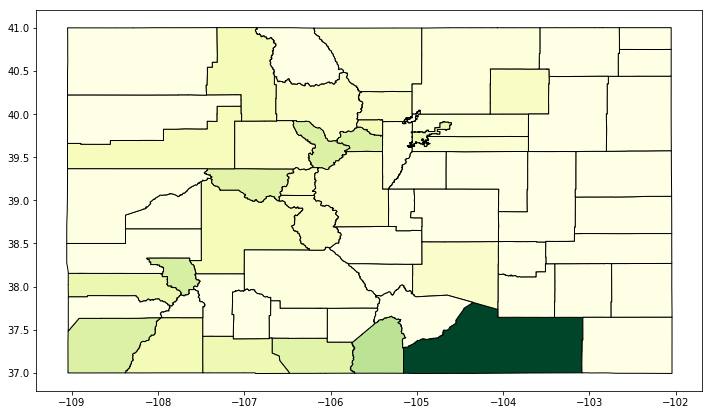

In [26]:
map_with_data.plot(column='per_capita',
                   edgecolor='black',
                   cmap='YlGn', 
                   figsize=(13,7))

Spot the outlier ...